# Random Walk Approaches for Node Embeddings

## Random Walk
![](figures/03-nodeemb_20.jpeg)
![](figures/03-nodeemb_21.jpeg)

In [1]:
import networkx as nx
import numpy as np

G = nx.Graph()
G.add_nodes_from(range(1,13))
G.add_edges_from([
        (1, 2), (1, 3), (1, 4),
        (2, 3), (2, 8), 
        (3, 4), 
        (4, 5), 
        (5, 6), (5, 7), (5,8),
        (6,7), (8, 9), (8, 11),
        (9, 10), (10, 11), (10, 12),
        (11, 12)
    ])

def generate_walks(G, source_node, walk_len=5):
    walk = [source_node]
    for _ in range(walk_len):
        walk_options = list(G.neighbors(source_node))
        source_node = np.random.choice(walk_options)
        walk.append(source_node)
    return walk

In [2]:
generate_walks(G, 4, walk_len=5)

[4, 3, 2, 1, 4, 3]

![](figures/03-nodeemb_22.jpeg)
![](figures/03-nodeemb_23.jpeg)
![](figures/03-nodeemb_24.jpeg)

## Unsupervised Feature Learning
![](figures/03-nodeemb_25.jpeg)
![](figures/03-nodeemb_26.jpeg)

### Random Walk Optimization
![](figures/03-nodeemb_27.jpeg)
![](figures/03-nodeemb_28.jpeg)
![](figures/03-nodeemb_29.jpeg)
![](figures/03-nodeemb_31.jpeg)

### Negative Sampling
![](figures/03-nodeemb_32.jpeg)
![](figures/03-nodeemb_33.jpeg)

### Stochastic Gradient Descent
![](figures/03-nodeemb_34.jpeg)
![](figures/03-nodeemb_35.jpeg)

![](figures/03-nodeemb_36.jpeg)
![](figures/03-nodeemb_37.jpeg)

It is straightforward to obtain the embeddings from an unbiased walk strategy. We just need to generate a "corpus" of random walks and feed it into an off-the-shelf package of `Word2Vec`. 

In [3]:
import networkx as nx
import numpy as np
from gensim.models import Word2Vec

np.random.seed(42)

G = nx.Graph()
G.add_nodes_from(range(1,13))
G.add_edges_from([
        (1, 2), (1, 3), (1, 4),
        (2, 3), (2, 8), 
        (3, 4), 
        (4, 5), 
        (5, 6), (5, 7), (5,8),
        (6,7), (8, 9), (8, 11),
        (9, 10), (10, 11), (10, 12),
        (11, 12)
    ])


def generate_walks(G, source_node=None, walk_len=40):
    if source_node is None:
        source_node = np.random.choice(list(G.nodes()))
    walk = [source_node]
    for _ in range(walk_len):
        walk_options = list(G.neighbors(source_node))
        source_node = np.random.choice(walk_options)
        walk.append(source_node)
    return walk


walk_corpus = [generate_walks(G) for _ in range(1000)]
model = Word2Vec(walk_corpus, vector_size=2, window=10, min_count=0)

/Users/runmin/local/cs224w_annotated/network/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


As we can see, the embeddings accurately reflect the orginal graph.

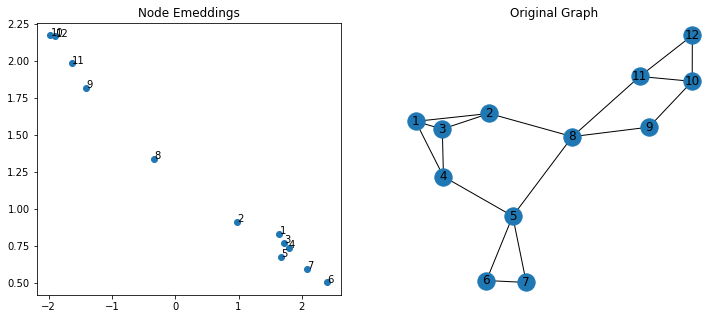

In [7]:
import matplotlib.pyplot as plt
node_embeddings = {node:model.wv[node] for node in sorted(G.nodes())}
node_embeddings = np.stack(list(node_embeddings.values()))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(node_embeddings[:,0], node_embeddings[:,1])
for label in G.nodes():
    ax[0].annotate(label, model.wv[label])
ax[0].set_title("Node Emeddings")
    
nx.draw(G, with_labels=True, ax=ax[1])
ax[1].set_title("Original Graph")

plt.show()

## Node2Vec
![](figures/03-nodeemb_38.jpeg)
![](figures/03-nodeemb_39.jpeg)
![](figures/03-nodeemb_40.jpeg)
![](figures/03-nodeemb_41.jpeg)
![](figures/03-nodeemb_42.jpeg)
![](figures/03-nodeemb_43.jpeg)
![](figures/03-nodeemb_44.jpeg)
![](figures/03-nodeemb_45.jpeg)
![](figures/03-nodeemb_46.jpeg)

## Rejection Sampling
When simulating the random walks, one can use the rejection sampling method to transverse all neighbor nodes. Suppose the latest walk is from $S_1$ to $W$, the rejection sampling to generate the next walk:

1. Randomly choose one neighbor $n$ of $W$
2. Determine the probablity weight $\alpha(S_1, W)$ by checking the distance between $n$ and $S_1$
3. Generate a random number $rand$. If $rand <= \alpha(S_1, W)$, push $n$ to the walk path. Otherwise, return to step 1. 

More details can be found from this [post](https://louisabraham.github.io/articles/node2vec-sampling.html)

In [6]:
import numpy as np

def random_neighbor(node):
    return np.random.choice(list(G.neighbors(node)))

def random_walk(walk_length, p, q, source_node):
    """sample a random walk starting from t
    """
    max_prob = max(1 / p, 1, 1 / q)
    prob_0 = 1 / p / max_prob
    prob_1 = 1 / max_prob
    prob_2 = 1 / q / max_prob

    # Initialize the walk
    walk = np.empty(walk_length, dtype=type(source_node))
    walk[0] = source_node 
    walk[1] = random_neighbor(source_node)

    for j in range(2, walk_length):
        while True:
            new_node = random_neighbor(walk[j - 1])
            r = np.random.rand()
            if new_node == walk[j - 2]:
                # back to the previous node
                if r < prob_0:
                    break
            elif new_node in G.neighbors(walk[j - 2]):
                # distance 1
                if r < prob_1:
                    break
            elif r < prob_2:
                # distance 2
                break
        walk[j] = new_node
        
    return walk

![](figures/03-nodeemb_47.jpeg)
![](figures/03-nodeemb_48.jpeg)
![](figures/03-nodeemb_49.jpeg)